This notebook was used to develop our job script for running the model, includes helper functions etc. More relevant to look at final script instead of this notebook

In [1]:
%%capture magic
# ! pip install ftfy regex tqdm;
# ! pip install git+https://github.com/openai/CLIP.git;
import numpy as np
import torch
import clip
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections  import OrderedDict
import pickle
import random
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as prfs


# from google.colab import drive
# drive.mount('/gdrive')
model, preprocess = clip.load('ViT-B/32')
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size);

In [2]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14']

In [ ]:
# original_images = []
# images = []
# texts = []
# source = "./mapillary/mapillary1" 
# data = pickle.load(open(f"geoguessr-ai/metadata_w_google.pickle","rb"))
# plt.figure(figsize=(16, 5))
# error_name_list = []

# file_country = {}
# for key in data.keys():
#     for i in range(len(data[key]["results"])):
#         if "country" in data[key]["results"][i]["types"]:
#             country = data[key]["results"][i]["address_components"][0]["long_name"]
#             file_country[key] = country

# for filename in tqdm([filename for filename in os.listdir(f"{source}/train") if filename.endswith(".jpg")]):
#     name = os.path.splitext(filename)[0]
#     if name not in data:
#         continue
#     image = Image.open(f"{source}/train/{filename}").convert("RGB")
#     if len(images) + 1 < 9: # find a smarter solution than early breaking
#         plt.subplot(2, 4, len(images) + 1)
#         plt.imshow(image)
#         plt.title(f"{filename}\n{file_country[name]}")
#         plt.xticks([])
#         plt.yticks([])

#     if name in file_country:
#         original_images.append(image)
#         images.append(preprocess(image))
#         texts.append(file_country[name])
#     else:
#         error_name_list.append(name)
        
# plt.tight_layout()
# print(len(error_name_list))

 30%|██████████████████████▌                                                     | 10497/35341 [05:42<13:44, 30.13it/s]

In [5]:
image_src = "../mapillary/mapillary1/train" 
batch_size = 1000

In [6]:
data = pickle.load(open(f"metadata_w_google.pickle","rb"))
file_country = {}
for key in data.keys():
    for i in range(len(data[key]["results"])):
        if "country" in data[key]["results"][i]["types"]:
            country = data[key]["results"][i]["address_components"][0]["long_name"]
            file_country[key] = country

def get_data(batch_size = 1000, image_src = "", text_data = {},verbose=False,final_batch=True):
    max_batch_num = len(os.listdir(f"{image_src}"))//batch_size
    remainder = len(os.listdir(f"{image_src}"))%batch_size
    for batch_num in range(max_batch_num+1):
        
        images = []
        texts = []
        
        if batch_num == max_batch_num and remainder == 0:
            continue
        elif batch_num == max_batch_num and final_batch == True:
            filenames = [filename for filename in os.listdir(f"{image_src}")[max_batch_num*batch_size::] if filename.endswith(".jpg")]
        elif batch_num == max_batch_num and final_batch != True:
            continue
        else:
            filenames = [filename for filename in os.listdir(f"{image_src}")[batch_num*batch_size:(batch_num+1)*batch_size] if filename.endswith(".jpg")]
        
        for filename in filenames:
            name = os.path.splitext(filename)[0]
            if name not in text_data:
                if verbose: print("missing: ", name)
                continue
                
            image = Image.open(f"{image_src}/{filename}").convert("RGB")


            if name in file_country:
                images.append(preprocess(image))
                texts.append(text_data[name])
            else:
                error_name_list.append(name)
                
        yield images, texts, filenames
    
    
def convert_from_desc(text,start_text,end_text):
    text = text.replace(start_text, "")
    text = text.replace(end_text, "")
    return text
    

In [7]:
image_src = "../mapillary/mapillary1/train" 
batch = 0
all_labels = []
all_texts = []
for images, texts, filenames in get_data(batch_size = 1000, image_src = image_src, text_data = file_country):
    print("Got batch number: ", batch)
    combined = list(zip(images, texts, filenames))
    random.shuffle(combined)
    images[:], texts[:], filenames[:] = zip(*combined)
    image_input = torch.tensor(np.stack(images)).cuda()
    start_text = "This is a photo of "
    end_text = ", a country"
    text_descriptions = [f"{start_text}{cc}{end_text}" for cc in set(file_country.values())]
    text_tokens = clip.tokenize(text_descriptions).cuda()
    
    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
        text_features = model.encode_text(text_tokens).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(1, dim=-1)
    all_labels.extend([[label.item() for label in image] for image in top_labels])
    all_texts.extend(texts)
    
    batch += 1
    if batch == 1:
        break


    

Got batch number:  0


In [11]:
top_label_text = [[convert_from_desc(text_descriptions[labels[x]],start_text,end_text) for x in range(len(labels))] for labels in all_labels]

# count = 0
# for x,y in zip(top_label_text,all_texts):
#     if y in x: count += 1
# print(count/len(all_labels))


In [30]:
top_label_text = [x[0] for x in top_label_text]

In [31]:
prfs(all_texts, top_label_text, average="weighted")

(0.590850272561817, 0.2998527079084523, 0.34273774973472887, None)

In [34]:
prfs(all_texts, top_label_text, average="macro")

(0.1669102194341152, 0.2503957050490188, 0.13066719738351681, None)

In [32]:
len(set(all_texts))

159

In [33]:
len(set(top_label_text))

159

In [21]:
f1_score(all_texts, top_label_text, average='weighted')

0.3289532319333544

In [35]:
from collections import Counter
from math import log
c_counts = Counter(list(file_country.values()))
sorted_ = list(c_counts.items())
sorted_.sort(reverse=False, key= lambda x: x[1])
countries, counts = zip(*sorted_)

In [37]:
#sorted_

<BarContainer object of 159 artists>

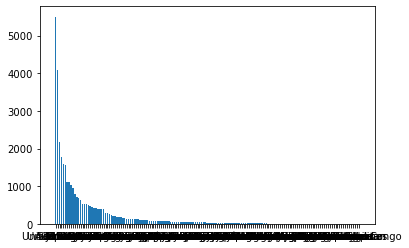

In [33]:
plt.bar(countries,counts)

In [ ]:
texts